# Demographic income

The dataset contains a set of demographic attributes for people in the US.

[Adult UCI Dataset](http://archive.ics.uci.edu/ml/datasets/Adult)

You have to build a model to predict whether their salary is higher or lower than 50K.

## 1. Data exploration

The data is contained in the database file: `../../assets/datasets/adult.sqlite`

Load the data into a Pandas Dataframe

In [95]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('../../assets/datasets/adult.sqlite') 
c = conn.cursor()
c.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()

columns = c.execute("PRAGMA table_info(adult)").fetchall()
columns = [x[1] for x in columns]

adult = pd.DataFrame(c.execute("SELECT * FROM adult").fetchall(), columns = columns)
adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### 1 Missing values

Are there any missing values?
How will you deal with them?

Discuss this with your classmate and decide on a strategy for imputation

In [96]:
#I would rather see "other" than lose data for these classifications

#work classification Nones to "other
adult['workclass'] = adult['workclass'].fillna("Other")
#occupation Nones to "other
adult['occupation'] = adult['occupation'].fillna("Other")
#native-country Nones to "other
adult['native-country'] = adult['native-country'].fillna("Other")
# adult.info()
adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## 2. Target

Salary is separated in 2 classes '<=50K' and '>50K'.

Create a new boolean variable called target that is True for salary >50K and False otherwise

In [102]:
adult['target'] = (adult.salary == '>50K').astype(int)
adult['target'].value_counts()


0    37155
1    11687
Name: target, dtype: int64

### 3 Features

The dataset contains many features.

- Are they numerical?
- Are they categorical?

> Some and some

### 3.a Age distribution

What is the distribution of age? How does age correlate with the outcome variable?

- Plot a histogram of the age column
- Separate by target variable and plot the age distribution for the 2 classes

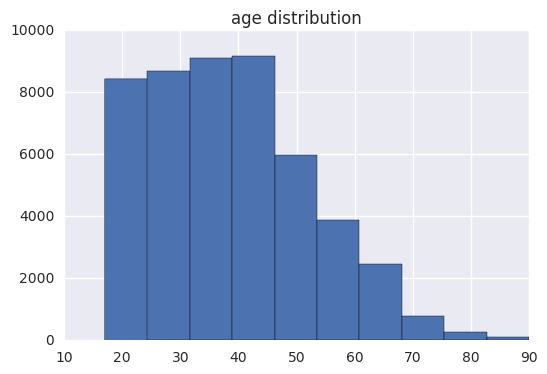

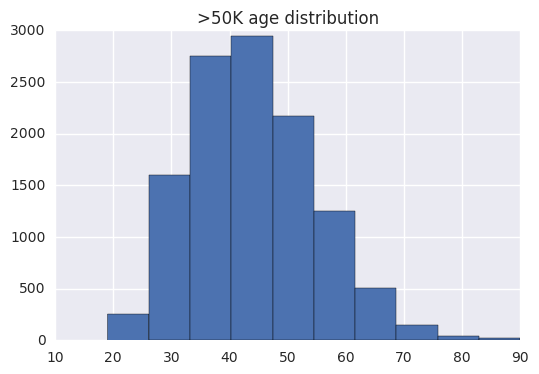

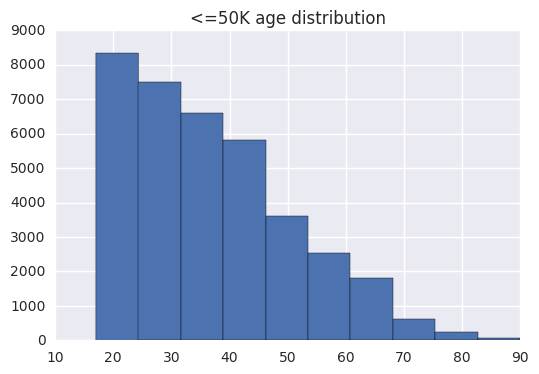

correlation between target and age


,target,age
target,1.000000,0.230369
age,0.230369,1.000000


In [139]:
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
%matplotlib inline

def class_plotter(category):
    plt.hist(adult[category])
    plt.title("%s distribution" % category)
    plt.show()
    
    plt.hist(adult[adult['target'] == 1][category])
    plt.title(">50K %s distribution" % category)
    plt.show()

    plt.hist(adult[adult['target'] == 0][category])
    plt.title("<=50K %s distribution" % category)
    plt.show()
    
class_plotter('age')
#Age distribution is skewed to the left

print "correlation between target and age"
adult[['target','age']].corr()

The only thing that is clearly visible is that there are many more young people in the low income class.

### 3.b Categorical Features Distributions

Investigate the relation of each categorical feature with the salary class:

- workclass
- education
- marital-status
- occupation
- relationship
- race
- sex

Use a bar-chart to visualize the relative frequency of each of the  elements in the group.
Use two colors to distinguish between the low and high salary class.

For which features is there significant difference in ratios?

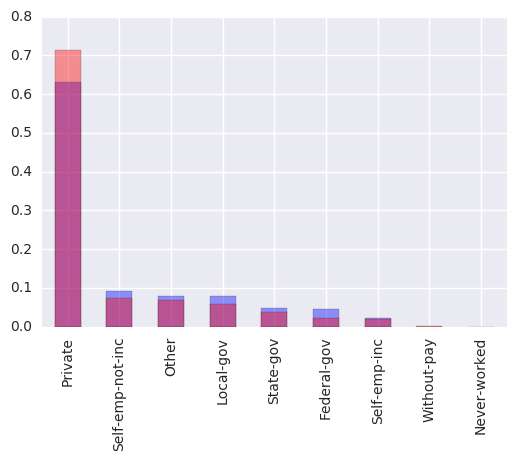

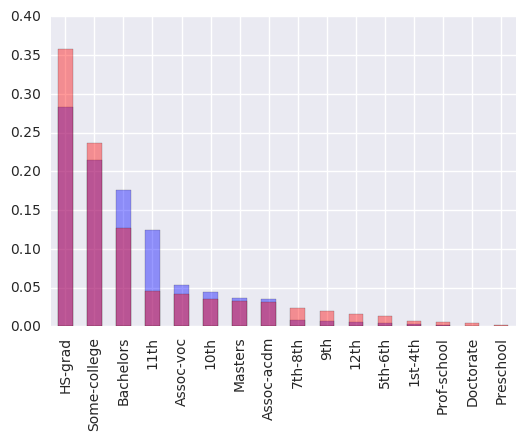

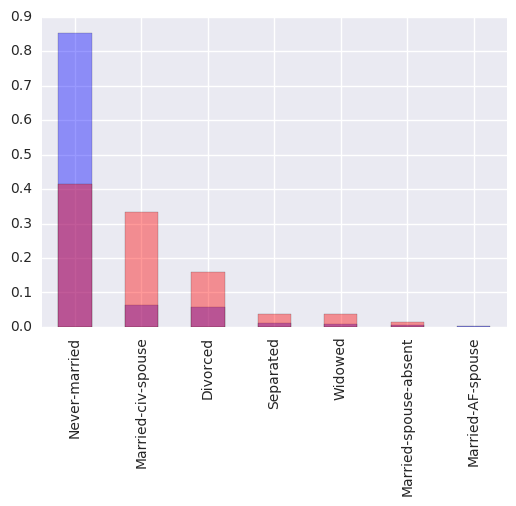

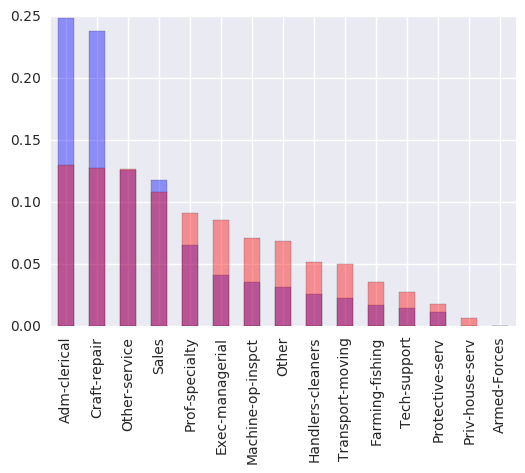

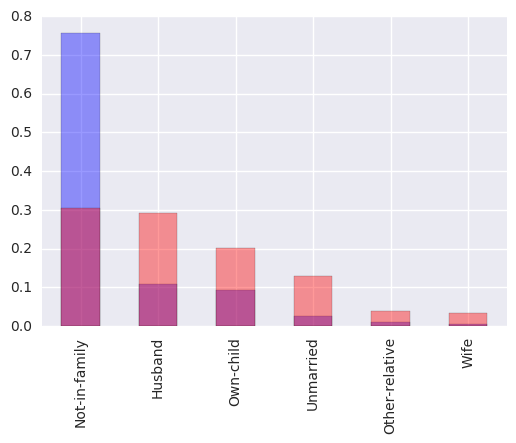

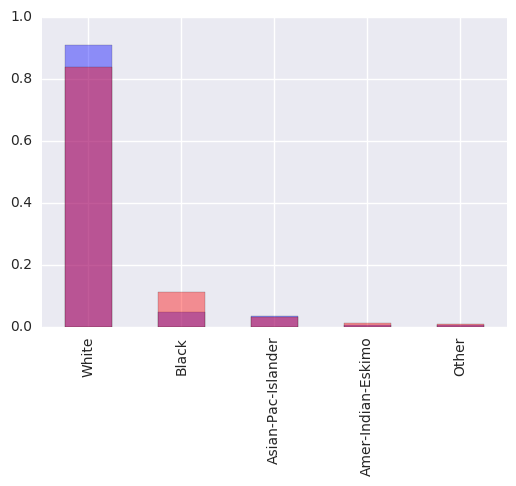

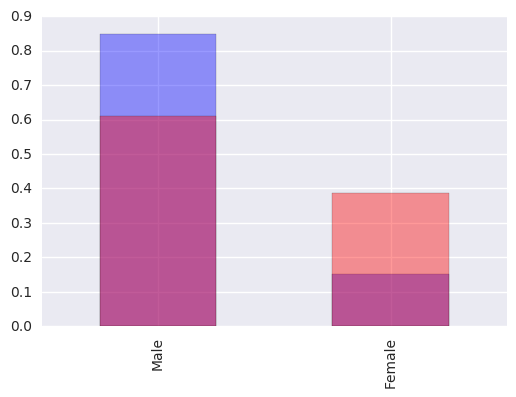

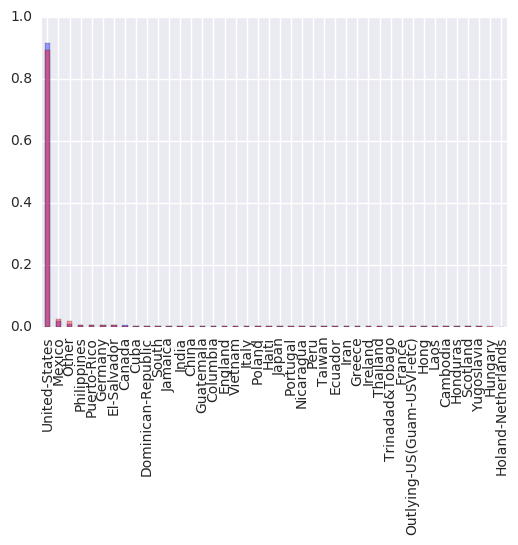

In [233]:
import seaborn as sns
import numpy as np

categoricals = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country']

for c in categoricals:
    trues = adult[adult['target'] == 1][c].value_counts() / adult[adult['target'] == 1][c].count()
    falses = adult[adult['target'] == 0][c].value_counts() / adult[adult['target'] == 0][c].count()

    trues.plot(kind='bar', alpha = 0.4, color = 'blue')
    falses.plot(kind='bar', alpha = 0.4, color = 'red')
    plt.show()

### 3.c Other numerical features distribution

Like you did for age, investigate the distribution of other numerical features for the 2 classes.

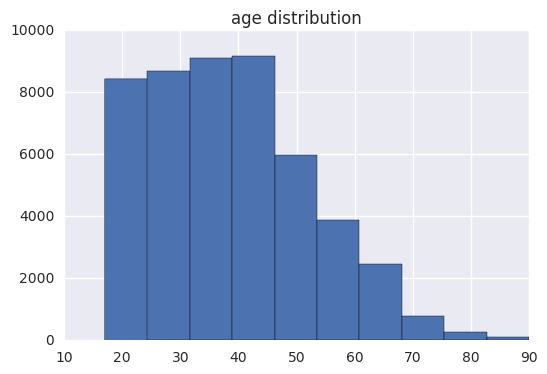

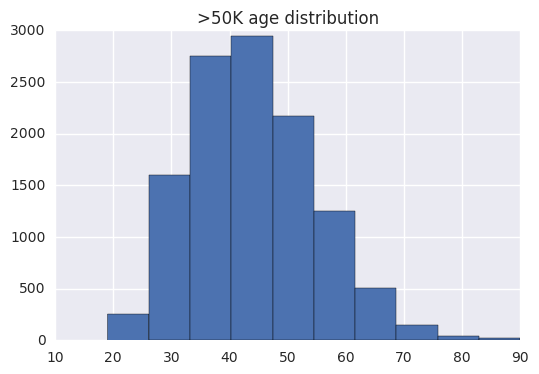

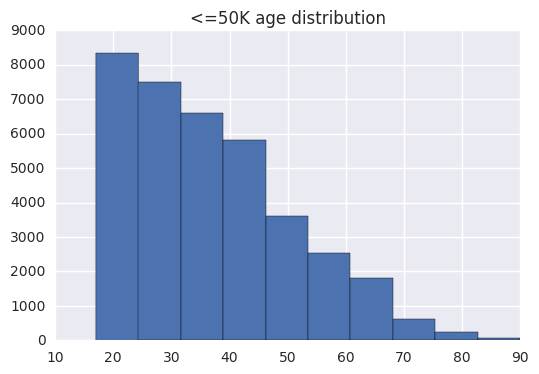

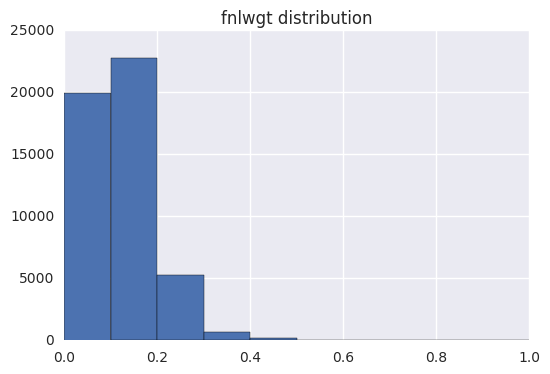

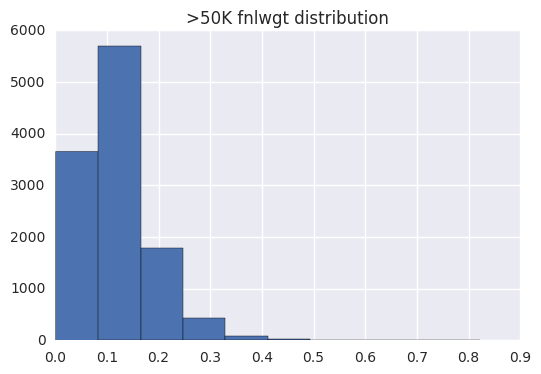

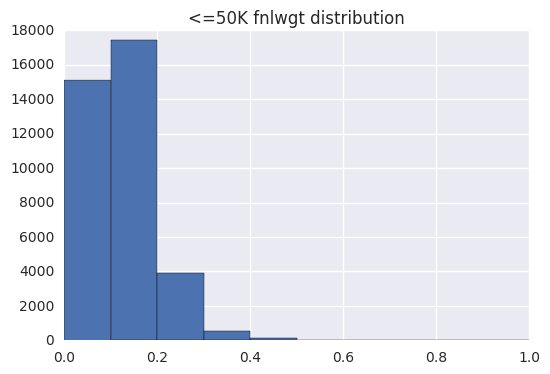

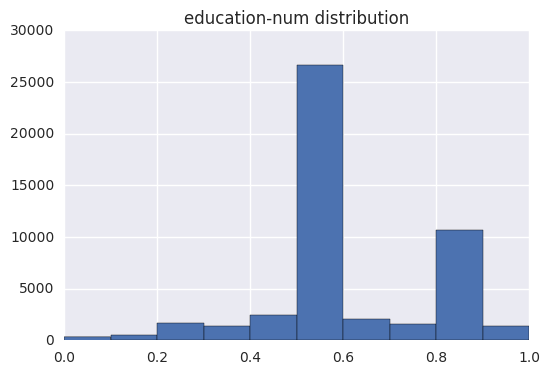

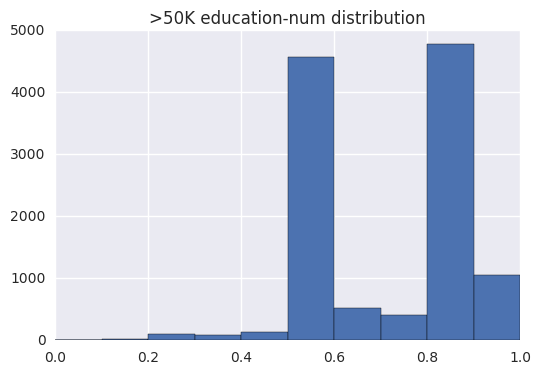

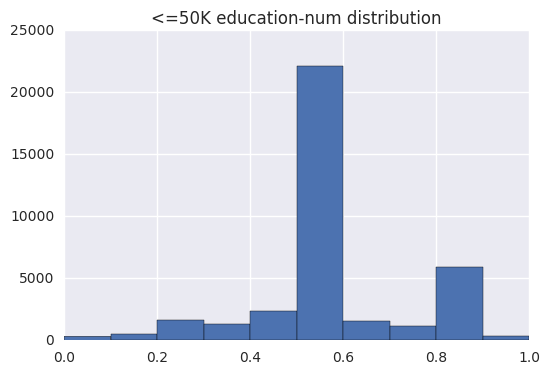

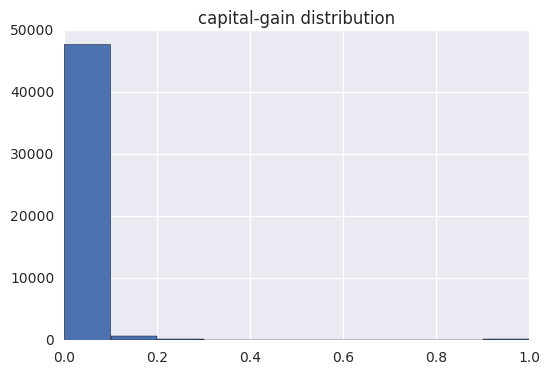

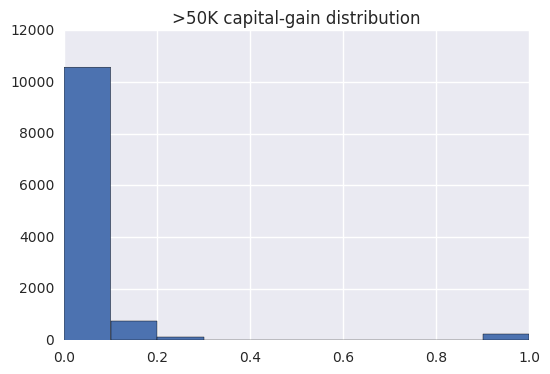

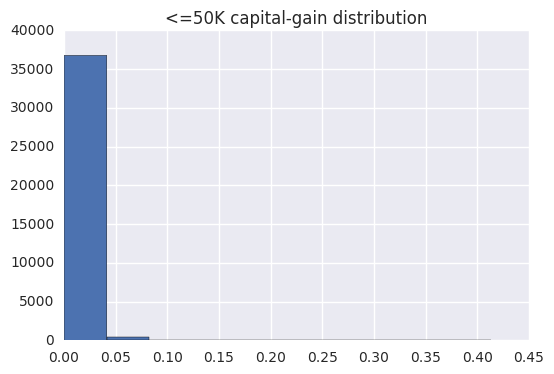

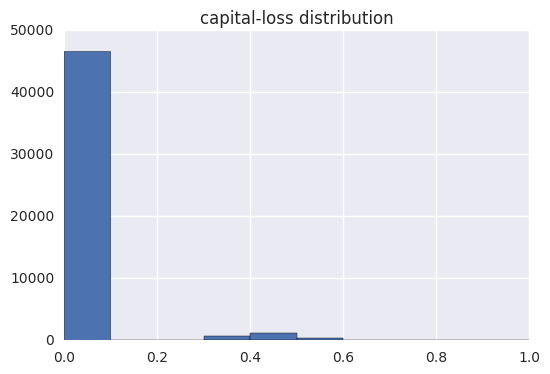

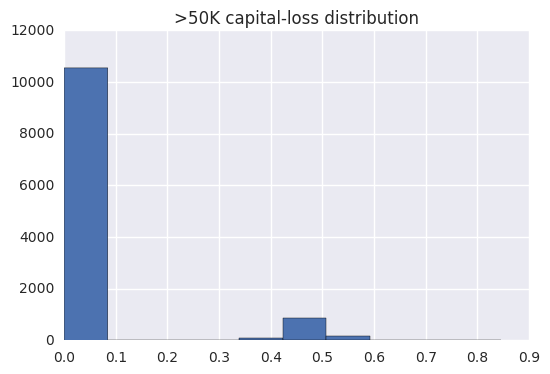

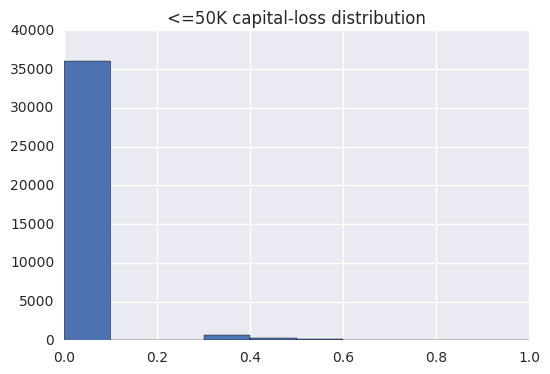

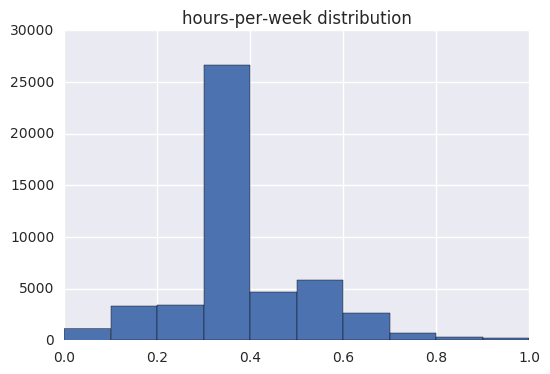

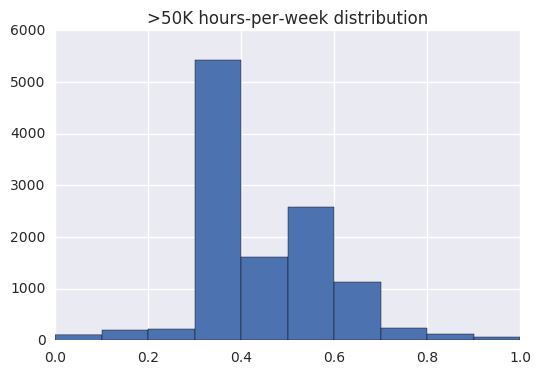

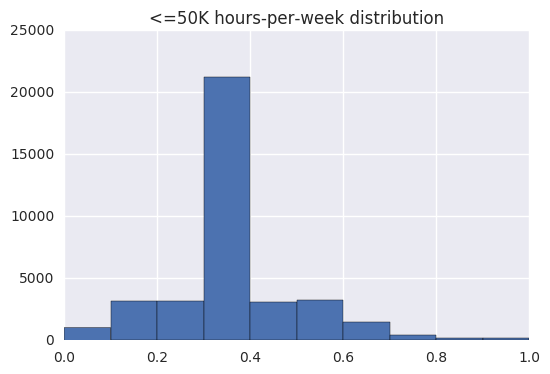

In [213]:
numericals = ["age","fnlwgt","education-num","capital-gain","capital-loss","hours-per-week"]
for col in numericals:
    class_plotter(col)


## 4. Dummy Columns

Scikit-Learn models require features with numerical values. In order to use all the categorical features in our model, we need to encode them into numbers. The way of doing this called 1-Hot Encoding, or dummy column creation.
Both Pandas and Scikit Learn offer an interface to do this. Please feel free to choose whichever you prefer.

Example:

|Categorical Feature|Dummy_A|Dummy_B|Dummy_C|
|---|---|---|---|
|A|1|0|0|
|B|0|1|0|
|B|0|1|0|
|C|0|0|1|
|A|1|0|0|
|C|0|0|1|
|B|0|1|0|

- [One Hot Encoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)
- [Get Dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)


In [212]:
dummy = pd.get_dummies(adult)

## 5. Numerical Features normalization

Numerical Features may have different scales. This can be a problem in some cases, so we can try to normalize using a scaler.

Use a scaler from Scikit-learn Preprocessing to rescale the numerical features.

[Scikit-Learn Preprocessing](http://scikit-learn.org/stable/modules/preprocessing.html)

Discuss within your team about pros/cons of each scaler.

In [162]:
from sklearn import preprocessing
dummy.head()

dummy[numericals] = scaler.fit_transform(dummy[numericals])
dummy.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,target,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,salary_<=50K,salary_>50K
0,39,0.044131,0.800000,0.02174,0.0,0.397959,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,50,0.048052,0.800000,0.00000,0.0,0.122449,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,38,0.137581,0.533333,0.00000,0.0,0.397959,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,53,0.150486,0.400000,0.00000,0.0,0.397959,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,28,0.220635,0.800000,0.00000,0.0,0.397959,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## 6. Combine Features

Combine the dummy features and the scaled feature into a single dataset called `X`.

Rename the target variable `y`.

What's the accuracy score of a benchmark model? What's the simplest model you could build?

In [176]:
X = dummy
X.head()

acc = X['target'].value_counts()[1] / float(len(X['target']))
print "accuracy: %.2f percent" % (acc * 100)
print "a model just guessing with this probability is the simplest I could make"

accuracy: 23.93 percent
a model just guessing with this probability is the simplest I could make


## 7. Build and evaluate model

Build a model using KNN or Logistic regression.

Split your data into train and test subset using the following line:

    from sklearn.cross_validation import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    
1. Evaluate the `accuracy_score` of your model.
- Display the confusion matrix and the classification report
- Try to improve the model by tuning the parameters. For example:
    - KNN: Change the number of Neighbors
    - LogisticRegression: Change the strength of the regularization
    
Discuss and compare your best model with other teams


In [235]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

y = adult['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
logreg = LogisticRegression(C=.000001, penalty='l1', solver='liblinear')
logreg.fit(X_train, y_train)

print "Accuracy of model"
print logreg.score(X_test,y_test)

logreg = LogisticRegression(C=.000001, penalty='l1', solver='liblinear')
logreg.fit(X, y)

Y_score = logreg.decision_function(X)
Y_proba_score = logreg.predict_proba(X)

Y_pred = logreg.predict(X_test)

conmat = confusion_matrix(y_test, Y_pred, labels=logreg.classes_)
confusion = pd.DataFrame(conmat, index=['>50k', '<=50k'],
                     columns=['predicted_>50k','predicted_<=50k'])
print(confusion)

print(classification_report(y_test, Y_pred))


Accuracy of model
0.757165901477
       predicted_>50k  predicted_<=50k
>50k            12204                0
<=50k            3914                0
             precision    recall  f1-score   support

          0       0.76      1.00      0.86     12204
          1       0.00      0.00      0.00      3914

avg / total       0.57      0.76      0.65     16118



In [206]:
from sklearn.grid_search import GridSearchCV

logreg = LogisticRegression()
C_vals = [0.0001, 0.001, 0.01, 0.1, 1.0, 100.0, 1000.0]
penalties = ['l1','l2']

gs = GridSearchCV(logreg, {'penalty':penalties, 'C':C_vals}, verbose=True, cv=2, scoring='f1_macro')
gs.fit(X, y)

# Get the best C_val and regularization to use.
gs.best_params_


Fitting 2 folds for each of 14 candidates, totalling 28 fits


[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:   39.8s finished


{'C': 1.0, 'penalty': 'l1'}

In [207]:
# use this parameter to .fit, .predict, and print a classification_report for our X and Y
gs_logreg = LogisticRegression(C=1.0, penalty='l1', solver='liblinear')
gs_logreg.fit(X, y)
Y_ = gs_logreg.predict(X)
print(classification_report(y, Y_))

             precision    recall  f1-score   support

          0       0.88      0.93      0.91     37155
          1       0.74      0.60      0.66     11687

avg / total       0.85      0.85      0.85     48842

